# lasagne
* lasagne - это библиотека для написания нейронок произвольной формы на theano
* библиотека низкоуровневая, границы между theano и lasagne практически нет

В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
* картинки 28x28
* 10 цифр

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape, y_train.shape

(50000, 1, 28, 28) (50000,)


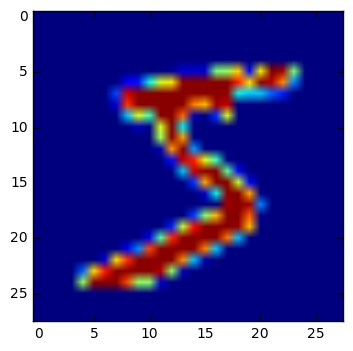

In [3]:
plt.imshow(X_train[0,0])

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [5]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape=(None,1,28,28), input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=50, nonlinearity=sigmoid, name="hidden_dense_layer")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10, nonlinearity=softmax)

In [6]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [7]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[hidden_dense_layer.W, hidden_dense_layer.b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [8]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [9]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить
* данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
* для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [10]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# inputs - тензор из картинок размером (много, 1, 28, 28), например - X_train
# targets - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
# batchsize - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать targets и targets одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batchsize картинок и ответов
# - если число картинок не делится на batchsize, одну подгруппу можно вернуть другого размера
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [11]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 0.847s
  training loss (in-iteration):		0.282389
  train accuracy:		91.79 %
  validation accuracy:		94.89 %
Epoch 2 of 10 took 0.766s
  training loss (in-iteration):		0.140599
  train accuracy:		95.85 %
  validation accuracy:		95.94 %
Epoch 3 of 10 took 0.827s
  training loss (in-iteration):		0.106651
  train accuracy:		96.82 %
  validation accuracy:		96.19 %
Epoch 4 of 10 took 0.939s
  training loss (in-iteration):		0.086713
  train accuracy:		97.45 %
  validation accuracy:		96.47 %
Epoch 5 of 10 took 0.865s
  training loss (in-iteration):		0.073688
  train accuracy:		97.85 %
  validation accuracy:		96.24 %
Epoch 6 of 10 took 0.816s
  training loss (in-iteration):		0.064315
  train accuracy:		98.17 %
  validation accuracy:		96.14 %
Epoch 7 of 10 took 0.912s
  training loss (in-iteration):		0.058444
  train accuracy:		98.26 %
  validation accuracy:		96.30 %
Epoch 8 of 10 took 1.469s
  training loss (in-iteration):		0.050523
  train accuracy:		98.57 %
  validation acc

In [12]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		96.39 %
Нужно больше магии!


# Нейронка твоей мечты


* Задача - сделать нейронку, которая получит точность 99% на валидации (validation accuracy)
 * Вариант "is fine too" - 97.5%. 
 * Чем выше, тем лучше.
 
__ В конце есть мини-отчётик, который имеет смысл прочитать вначале и заполнять по ходу работы. __
 

## Что можно улучшить:



 * размер сети
   * бОльше нейронов, 
   * бОльше слоёв, 
   
 * регуляризация - чтобы не переобучалось
   * приплюсовать к функции ошибки какую-нибудь сумму квадратов весов
   * можно сделать вручную, а можно - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - для борьбы с переобучением
       * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
 * Метод оптимизации - adam, rmsprop, nesterov_momentum, adadelta, adagrad и т.п.
   * сходятся быстрее и иногда - к лучшему оптимуму
   * имеет смысл поиграть с размером батча, количеством эпох и скоростью обучения
   
 * Наконец, можно поиграть с нелинейностями в скрытых слоях
   * tanh, relu, leaky relu, etc

In [13]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape,y_train.shape

(50000, 1, 28, 28) (50000,)


In [33]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = (None,1,28,28)

target_y = T.vector("target Y integer",dtype='int32')

In [34]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

drop_input = lasagne.layers.DropoutLayer(input_layer, p = 0.8)
dense_1 = lasagne.layers.DenseLayer(input_layer, num_units = 800, nonlinearity = leaky_rectify)
drop_1 = lasagne.layers.DropoutLayer(dense_1, p = 0.5)
dense_2 = lasagne.layers.DenseLayer(drop_1, num_units = 600, nonlinearity = leaky_rectify)
drop_2 = lasagne.layers.DropoutLayer(dense_2, p = 0.5)
#dense_3 = lasagne.layers.DenseLayer(drop_2, num_units = 150, nonlinearity = leaky_rectify)
#drop_3 = lasagne.layers.DropoutLayer(dense_3, p = 0.8)
#dense_4 = lasagne.layers.DenseLayer(drop_3, num_units = 75, nonlinearity = leaky_rectify)
#drop_4 = lasagne.layers.DropoutLayer(dense_4, p = 0.8)
#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(drop_2,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [35]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [36]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, output.W, output.b]


In [37]:
#функция ошибки - средняя кроссэнтропия
penalty = lasagne.updates.total_norm_constraint(all_weights, 500)
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean() #+ np.mean(penalty)

#<возможно добавить регуляризатор>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=1)

In [38]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [39]:
#итерации обучения

num_epochs = 10 #количество проходов по данным

batch_size = 150 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size, shuffle = True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 24.192s
  training loss (in-iteration):		0.385563
  train accuracy:		87.82 %
  validation accuracy:		93.58 %
Epoch 2 of 10 took 35.644s
  training loss (in-iteration):		0.172363
  train accuracy:		94.73 %
  validation accuracy:		95.49 %
Epoch 3 of 10 took 47.975s
  training loss (in-iteration):		0.136754
  train accuracy:		95.79 %
  validation accuracy:		96.08 %
Epoch 4 of 10 took 53.793s
  training loss (in-iteration):		0.112708
  train accuracy:		96.47 %
  validation accuracy:		96.57 %
Epoch 5 of 10 took 52.390s
  training loss (in-iteration):		0.096145
  train accuracy:		96.96 %
  validation accuracy:		96.55 %
Epoch 6 of 10 took 48.559s
  training loss (in-iteration):		0.087546
  train accuracy:		97.26 %
  validation accuracy:		96.65 %
Epoch 7 of 10 took 52.067s
  training loss (in-iteration):		0.077902
  train accuracy:		97.55 %
  validation accuracy:		96.71 %


KeyboardInterrupt: 

In [299]:
all_weights

[W, b, W, b, output.W, output.b]

In [250]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Final results:
  test accuracy:		98.12 %


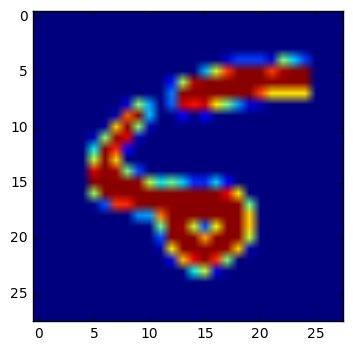

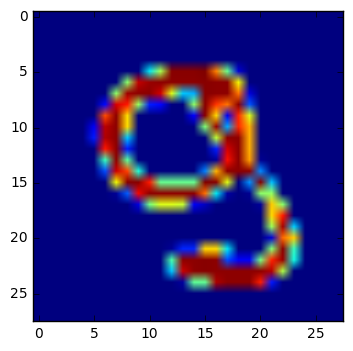

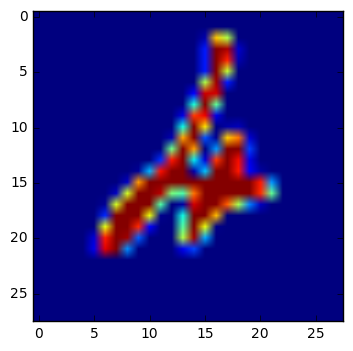

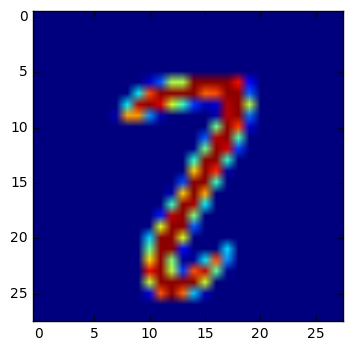

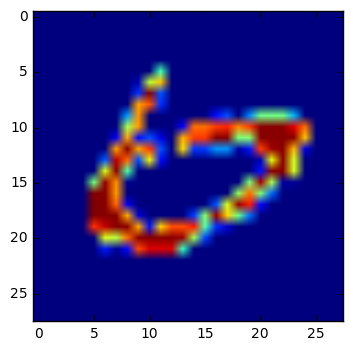

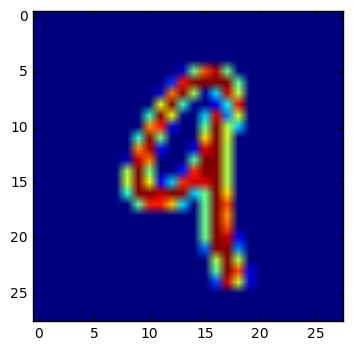

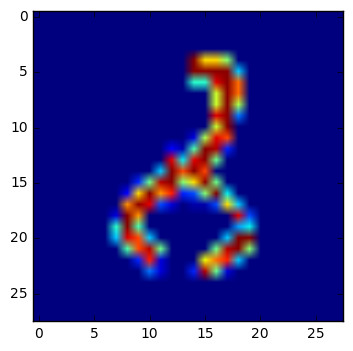

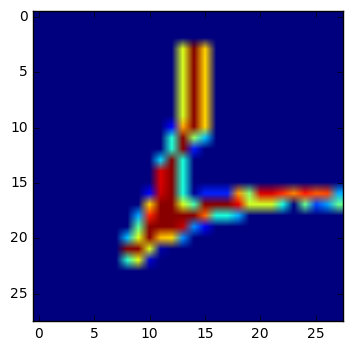

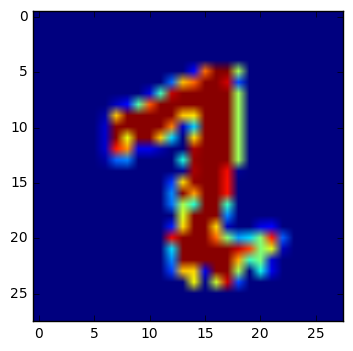

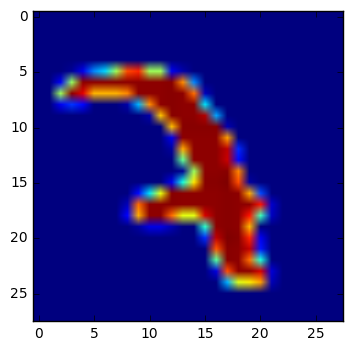

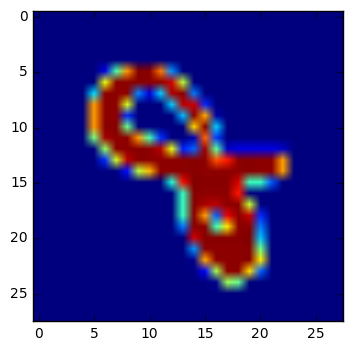

In [262]:
n = 0
for batch in iterate_minibatches(X_test, y_test, 1):
    inputs, targets = batch
    if  accuracy_fun(inputs, targets) < 1:
        n += 1
        plt.show(plt.imshow(inputs.reshape([28,28])))
    if n > 10:
        break
        



In [305]:
A = np.random.randn(5,6)
B = np.random.randn(3,4)
A.reshape(A.size)

array([ 0.86852279,  0.47620385, -1.37700416, -0.00957974,  0.92820681,
       -0.99725771, -0.3668444 ,  0.70913404, -0.23830011,  0.06185068,
        0.49974021, -1.61605113,  0.28721325, -0.48216971,  0.53269368,
       -0.69464261, -0.0199945 , -0.85452867, -1.9014503 ,  1.68947476,
       -1.03044852,  0.17246071, -0.94643695,  0.00783371, -1.1186374 ,
        0.45399227,  0.11426074, -1.31380165,  0.36197415, -0.52284698])

ValueError: total size of new array must be unchanged

In [327]:
np.max([1,2])

2

In [20]:
np.mean([1,2,6])

3.0